# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading libraries

In [1]:
import os
import time
import pickle
import numpy as np
import tensorflow as tf
from __future__ import print_function
from tqdm import tqdm
from urllib import urlretrieve
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from helpers import display_sample_images, preprocess_images, one_hot_encode, batch_creator

%matplotlib inline
tf.reset_default_graph()

## Loading VGG-16 trained model

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('./tensorflow_vgg/vgg16.npy'):
    try:
        from tensorflow_vvg import vgg16
    except:
        !git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
        from tensorflow_vgg import vgg16

    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            './tensorflow_vgg/vgg16.npy',
            pbar.hook)

print('Model loaded!')

VGG16 Parameters: 553MB [00:09, 60.1MB/s]                            

Model loaded!


## Load the dataset

In [3]:
if not os.path.isfile('../data/train_32x32.mat'):
    os.mkdir('../data')
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            '../data/train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('../data/train_32x32.mat')
print('Data loaded!')

SVHN Dataset: 182MB [00:12, 14.5MB/s]                              


Data loaded!


## Understanding the dataset

In [4]:
print(type(svhn_data))
print(svhn_data.keys())

<type 'dict'>
['y', 'X', '__version__', '__header__', '__globals__']


In [5]:
features = svhn_data['X']
labels = svhn_data['y']

print('X: {} ({} x {} x {}) images'.format(features.shape[3], features.shape[0],
                                           features.shape[1], features.shape[2]))
print('y: {} ({}) labels'.format(labels.shape[0], labels.shape[1]))
print('First 30 labels: {}'.format(labels[:30].reshape((1,-1))))
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

X: 73257 (32 x 32 x 3) images
y: 73257 (1) labels
First 30 labels: [[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8]]
Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


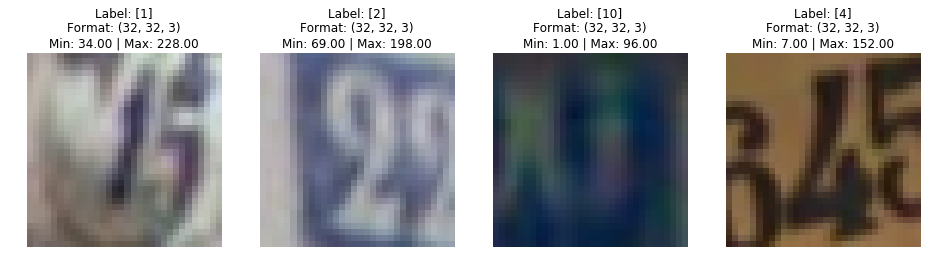

In [6]:
display_sample_images(features, labels, 4)

## Transfering learning (using a trained net)

In [7]:
if not os.path.isfile('./code_data.pkl'):
    batch_size = 8
    codes = None
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        images = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope('content_vgg'):
            vgg.build(images)
    
        for batch, _ in tqdm(batch_creator(features, labels, batch_size), desc='Training'):
            processed_batch = preprocess_images(batch)
            feed_dict = {images: processed_batch}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
        
    with open('./code_data.pkl', 'wb') as f:
        pickle.dump(codes, f)

/home/carnd/machine-learning/mlnd_capstone/project/tensorflow_vgg/vgg16.npy
npy file loaded
build model started


Training: 0it [00:00, ?it/s]

build model finished: 0s


Training: 9158it [1:48:26,  1.30s/it]


## Preporcessing part trained data

In [8]:
with open('./code_data.pkl', 'rb') as f:
    codes = pickle.load(f)
print(codes.shape)

(73257, 4096)


In [9]:
def normalize_data(features):
    return (features - np.mean(features)) / np.std(features)

norm_codes = normalize_data(codes)
print(np.min(norm_codes), np.max(norm_codes))

-0.40561 19.913


In [10]:
one_hot_labels = one_hot_encode(labels)
print(one_hot_labels.shape)

(73257, 10)


In [11]:
reduce_data = 20000

In [12]:
total_size = codes.shape[0]

if reduce_data is not None:
    total_size = reduce_data

train_size = 0.6
idx = np.arange(total_size)
np.random.shuffle(idx)
idx = list(idx)
split_point = int(total_size * train_size)
train_idx = idx[:split_point]
test_idx = idx[split_point:]

In [13]:
X_train = norm_codes[train_idx]
y_train = one_hot_labels[train_idx]
X_test = norm_codes[test_idx]
y_test = one_hot_labels[test_idx]

print('Train features: {} | Test features: {}'.format(X_train.shape, X_test.shape))
print('Train labels:   {}   | Test labels:   {}'.format(y_train.shape, y_test.shape))

Train features: (12000, 4096) | Test features: (8000, 4096)
Train labels:   (12000, 10)   | Test labels:   (8000, 10)


## Building the Neural Net

In [38]:
inputs_ = tf.placeholder(tf.float32, [None, codes.shape[1]])
labels_ = tf.placeholder(tf.float32, [None, one_hot_labels.shape[1]])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('fully_conn_content'):
    # continues the VGG16 architecture
    drop6 = tf.nn.dropout(inputs_, keep_prob)
    fc7 = tf.layers.dense(drop6, 4096, activation=tf.nn.relu)
    drop7 = tf.nn.dropout(fc7, keep_prob)
    logits = tf.layers.dense(drop7, one_hot_labels.shape[1])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_), name='cost')

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Trainning the model

In [39]:
epochs = 300
batch_size = 10240
val_size = 0.2
learn_rate = 0.01
keep_probability = 0.5
display_epoch = 10

In [41]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('/tmp/graphs/', sess.graph)
    
    if os.path.isdir('./checkpoints'):
        saver.restore(sess, "./checkpoints/svhn.ckpt")
        print('Trained model loaded!')
    else:
        for epoch in range(epochs):
            train_total_loss = 0
            train_total_acc = 0
            val_total_loss = 0
            val_total_acc = 0
            for feat_train, feat_val, lab_train, lab_val in batch_creator(X_train, y_train, batch_size, val_size, flatted=True):
                train_dict = {inputs_: feat_train,
                              labels_: lab_train,
                              learning_rate: learn_rate,
                              keep_prob: keep_probability
                             }
                _, train_loss, train_acc = sess.run([optimizer, cost, accuracy], feed_dict = train_dict)
                
                val_dict = {inputs_: feat_val,
                            labels_: lab_val,
                            keep_prob: 1.0
                           }
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict = val_dict)
            output = 'Epoch {:4d} | Train loss {:.3f} | Train acc {:.3f} | Val loss {:.3f} | Val acc {:.3f}'
            print(output.format(epoch, train_loss, train_acc, val_loss, val_acc))
            
        !mkdir ./checkpoints
        saver.save(sess, "./checkpoints/svhn.ckpt")

Epoch    0 | Train loss 337.645 | Train acc 0.102 | Val loss 444.919 | Val acc 0.148
Epoch    1 | Train loss 432.281 | Train acc 0.116 | Val loss 327.970 | Val acc 0.074
Epoch    2 | Train loss 200.434 | Train acc 0.097 | Val loss 62.560 | Val acc 0.085
Epoch    3 | Train loss 15.644 | Train acc 0.192 | Val loss 2.690 | Val acc 0.088
Epoch    4 | Train loss 2.419 | Train acc 0.130 | Val loss 2.314 | Val acc 0.068
Epoch    5 | Train loss 2.305 | Train acc 0.069 | Val loss 2.300 | Val acc 0.057
Epoch    6 | Train loss 2.303 | Train acc 0.072 | Val loss 2.300 | Val acc 0.188
Epoch    7 | Train loss 2.299 | Train acc 0.180 | Val loss 2.299 | Val acc 0.199
Epoch    8 | Train loss 2.298 | Train acc 0.187 | Val loss 2.298 | Val acc 0.173
Epoch    9 | Train loss 2.296 | Train acc 0.182 | Val loss 2.296 | Val acc 0.193
Epoch   10 | Train loss 2.295 | Train acc 0.180 | Val loss 2.294 | Val acc 0.199
Epoch   11 | Train loss 2.292 | Train acc 0.188 | Val loss 2.294 | Val acc 0.173
Epoch   12 | Tra

Epoch  101 | Train loss 2.232 | Train acc 0.189 | Val loss 2.239 | Val acc 0.165
Epoch  102 | Train loss 2.232 | Train acc 0.185 | Val loss 2.233 | Val acc 0.185
Epoch  103 | Train loss 2.234 | Train acc 0.187 | Val loss 2.227 | Val acc 0.176
Epoch  104 | Train loss 2.237 | Train acc 0.173 | Val loss 2.217 | Val acc 0.233
Epoch  105 | Train loss 2.235 | Train acc 0.185 | Val loss 2.224 | Val acc 0.185
Epoch  106 | Train loss 2.238 | Train acc 0.188 | Val loss 2.212 | Val acc 0.170
Epoch  107 | Train loss 2.229 | Train acc 0.186 | Val loss 2.247 | Val acc 0.179
Epoch  108 | Train loss 2.232 | Train acc 0.186 | Val loss 2.239 | Val acc 0.176
Epoch  109 | Train loss 2.233 | Train acc 0.185 | Val loss 2.233 | Val acc 0.182
Epoch  110 | Train loss 2.231 | Train acc 0.188 | Val loss 2.244 | Val acc 0.170
Epoch  111 | Train loss 2.229 | Train acc 0.185 | Val loss 2.254 | Val acc 0.179
Epoch  112 | Train loss 2.231 | Train acc 0.185 | Val loss 2.240 | Val acc 0.182
Epoch  113 | Train loss 2.24

Epoch  203 | Train loss 2.243 | Train acc 0.176 | Val loss 2.197 | Val acc 0.216
Epoch  204 | Train loss 2.233 | Train acc 0.183 | Val loss 2.233 | Val acc 0.188
Epoch  205 | Train loss 2.234 | Train acc 0.178 | Val loss 2.228 | Val acc 0.210
Epoch  206 | Train loss 2.226 | Train acc 0.192 | Val loss 2.263 | Val acc 0.153
Epoch  207 | Train loss 2.234 | Train acc 0.189 | Val loss 2.228 | Val acc 0.168
Epoch  208 | Train loss 2.226 | Train acc 0.190 | Val loss 2.265 | Val acc 0.162
Epoch  209 | Train loss 2.242 | Train acc 0.177 | Val loss 2.196 | Val acc 0.213
Epoch  210 | Train loss 2.229 | Train acc 0.183 | Val loss 2.247 | Val acc 0.190
Epoch  211 | Train loss 2.223 | Train acc 0.190 | Val loss 2.268 | Val acc 0.162
Epoch  212 | Train loss 2.232 | Train acc 0.188 | Val loss 2.238 | Val acc 0.173
Epoch  213 | Train loss 2.240 | Train acc 0.173 | Val loss 2.201 | Val acc 0.233
Epoch  214 | Train loss 2.237 | Train acc 0.179 | Val loss 2.218 | Val acc 0.205
Epoch  215 | Train loss 2.23

## Test

11584


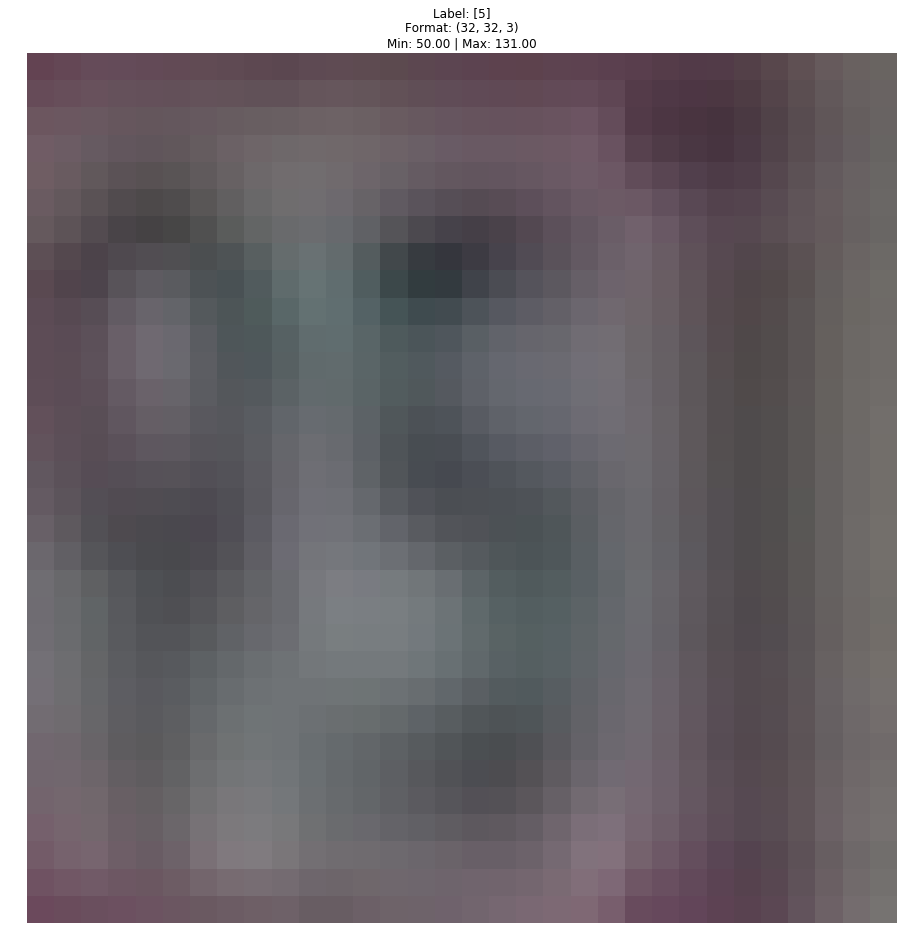

In [42]:
sample_image = np.random.choice(test_idx)
print(sample_image)
display_sample_images(features, labels, 1, test_data=sample_image)

In [46]:
sample_image_code = np.where(test_idx == sample_image)[0][0]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    test_dict = {inputs_: X_test[sample_image_code].reshape((-1, 4096)),
                labels_: y_test[sample_image_code].reshape((-1, 10)),
                keep_prob: 1.0
               }
    prediction = sess.run(predicted, feed_dict=test_dict)
print('Predicted: {}'.format(np.argmax(prediction, 1)))

Predicted: [9]
